In [ ]:
# CSA_analysis.py
# A small utility module for consistent, publication-ready plots.

from dataclasses import dataclass
from typing import Optional, Tuple, Literal, Dict
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Defaults and sizing presets
# -----------------------------

# Common journal column widths (in inches). Adjust to your target venue if needed.
COLUMN_WIDTHS = {
    "single": 3.5,   # typical single-column width ~ 85–90 mm
    "one_half": 4.5, # optional in-between
    "double": 7.2    # typical double-column width ~ 180 mm
}

# Golden ratio for aesthetically pleasing height
GOLDEN = 0.618

@dataclass
class PubParams:
    font: str = "Arial"       # Switch to "DejaVu Serif" or "Times New Roman" if preferred
    base_fontsize: int = 9          # 8–10 works well for many journals
    dpi_view: int = 120             # comfortable interactive viewing
    dpi_export: int = 300           # typical print requirement
    palette: str = "colorblind"     # seaborn colorblind-safe palette
    context: str = "paper"          # "paper", "talk", etc.
    style: str = "whitegrid"        # "white", "darkgrid", etc.
    tight_layout_pad: float = 0.02  # small padding for tight layout


def set_pub_style(params: Optional[PubParams] = None) -> Dict:
    """Apply a consistent, publication-friendly style."""
    if params is None:
        params = PubParams()

    # Seaborn theme (controls baseline aesthetics)
    sns.set_theme(
        context=params.context,
        style=params.style,
        palette=params.palette,
        font=params.font,
        rc={
            "axes.titlesize": params.base_fontsize + 1,
            "axes.labelsize": params.base_fontsize,
            "xtick.labelsize": params.base_fontsize - 1,
            "ytick.labelsize": params.base_fontsize - 1,
            "legend.fontsize": params.base_fontsize - 1,
            "figure.dpi": params.dpi_view,  # on-screen
            "savefig.dpi": params.dpi_export,  # for export
            "axes.spines.top": False,
            "axes.spines.right": False,
            "axes.linewidth": 0.8,
            "grid.linewidth": 0.6,
            "lines.linewidth": 1.6,
            "patch.linewidth": 0.8,
            "legend.frameon": False,
        },
    )

    # Matplotlib rc fine-tuning
    mpl.rcParams.update({
        "font.family": "sans-serif" if "Sans" in params.font else "serif",
        "pdf.fonttype": 42,  # embed TrueType fonts for better compatibility
        "ps.fonttype": 42,
        "mathtext.default": "regular",
        "figure.autolayout": False,  # we'll manage with tight_layout/constrained_layout
    })

    return {
        "palette": sns.color_palette(params.palette),
        "params": params,
    }


def figsize_for_columns(
    columns: Literal["single", "one_half", "double"] = "single",
    height: Optional[float] = None,
    aspect: Optional[float] = GOLDEN,
) -> Tuple[float, float]:
    """Return (width, height) in inches for common journal column widths."""
    width = COLUMN_WIDTHS[columns]
    if height is None:
        if aspect is None or aspect <= 0:
            aspect = GOLDEN
        height = width * aspect
    return (width, height)


def new_figure(
    columns: Literal["single", "one_half", "double"] = "single",
    height: Optional[float] = None,
    aspect: Optional[float] = GOLDEN,
    constrained_layout: bool = False,
) -> Tuple[plt.Figure, plt.Axes]:
    """Create a new figure with preset size."""
    w, h = figsize_for_columns(columns=columns, height=height, aspect=aspect)
    fig, ax = plt.subplots(figsize=(w, h), constrained_layout=constrained_layout)
    return fig, ax


def label_panel(ax: plt.Axes, label: str, x: float = -0.12, y: float = 1.02, **kwargs):
    """Add panel labels like '(a)', '(b)' in axes coordinates."""
    defaults = dict(fontweight="bold", fontsize=ax.xaxis.get_label().get_size())
    defaults.update(kwargs)
    ax.text(x, y, label, transform=ax.transAxes, va="bottom", ha="left", **defaults)


def finalize_axes(
    ax: plt.Axes,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None,
    title: Optional[str] = None,
    legend: bool = True,
    legend_loc: str = "best",
    xlim: Optional[Tuple[float, float]] = None,
    ylim: Optional[Tuple[float, float]] = None,
):
    """Set labels, limits, legend, and basic finishing touches."""
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)
    if xlim:
        ax.set_xlim(*xlim)
    if ylim:
        ax.set_ylim(*ylim)
    if legend:
        leg = ax.legend(loc=legend_loc)
        if leg:
            leg.set_frame_on(False)


def save_figure(
    fig: plt.Figure,
    path: str,
    dpi: Optional[int] = None,
    transparent: bool = False,
    formats: Tuple[str, ...] = ("png", "pdf"),
    bbox_inches: str = "tight",
    pad_inches: float = 0.02,
):
    """
    Save a figure to multiple formats at high quality.

    - Use PNG (raster) for quick sharing, set dpi=300+.
    - Use PDF/SVG (vector) for print or when journals require vector art.
    """
    # Respect module defaults if dpi not supplied
    if dpi is None:
        dpi = mpl.rcParams.get("savefig.dpi", 300)

    for fmt in formats:
        fig.savefig(
            f"{path}.{fmt}",
            dpi=dpi,
            transparent=transparent,
            bbox_inches=bbox_inches,
            pad_inches=pad_inches,
        )


# -----------------------------
# Example plot helpers
# -----------------------------

def example_line_with_ci(ax: plt.Axes, data, x, y, hue=None, ci=95, **kwargs):
    """Seaborn line plot with confidence interval."""
    sns.lineplot(ax=ax, data=data, x=x, y=y, hue=hue, ci=ci, **kwargs)
    ax.margins(x=0.02)


def example_scatter_with_trend(ax: plt.Axes, data, x, y, hue=None, **kwargs):
    """Scatter with LOWESS-like smoothing (seaborn regplot with lowess=True)."""
    sns.scatterplot(ax=ax, data=data, x=x, y=y, hue=hue, s=24, **kwargs)
    sns.regplot(ax=ax, data=data, x=x, y=y, scatter=False, lowess=True, color="0.3")


def example_box_violin(ax: plt.Axes, data, x, y, kind: Literal["box", "violin"] = "box", **kwargs):
    """Box or violin plot with minimal clutter."""
    if kind == "box":
        sns.boxplot(ax=ax, data=data, x=x, y=y, **kwargs)
        sns.stripplot(ax=ax, data=data, x=x, y=y, size=3, color="0.2", alpha=0.5, jitter=0.2)
    else:
        sns.violinplot(ax=ax, data=data, x=x, y=y, cut=0, inner=None, **kwargs)
        sns.stripplot(ax=ax, data=data, x=x, y=y, size=3, color="0.2", alpha=0.5, jitter=0.2)


def example_hist_kde(ax: plt.Axes, data, x, bins=30, **kwargs):
    """Histogram + KDE with shared color."""
    sns.histplot(ax=ax, data=data, x=x, bins=bins, stat="density", kde=True, **kwargs)
    ax.margins(x=0.02)

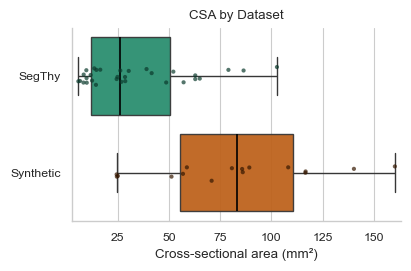

In [15]:
# ---- Paste your two columns below (no headers needed). Tabs/commas/spaces OK. ----
raw = """
102.7	160.3
86.4	140.3
79.0	116.7
65.0	116.6
62.8	108.2
62.8	89.2
57.1	86.0
52.1	85.7
48.6	80.7
41.5	70.8
39.0	58.7
30.3	56.8
28.6	51.2
28.5	25.0
26.7	24.5
26.2	24.4
24.8	
24.4	
16.4	
14.5	
14.3	
13.5	
12.4	
11.7	
9.8	
9.7	
9.6	
8.3	
8.2	
6.5	
5.7	
"""


# --------------------- No edits needed below this line ---------------------
import io
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def _read_two_cols(text: str) -> pd.DataFrame:
    text = text.strip()
    if not text:
        raise ValueError("No data found. Paste two numeric columns into the raw string.")

    # Explicitly use engine='python' where regex/whitespace splitting is expected
    attempts = [
        # CSV with commas
        lambda t: pd.read_csv(io.StringIO(t), header=None, sep=","),
        # TSV with regex tabs
        lambda t: pd.read_csv(io.StringIO(t), header=None, sep=r"\t+", engine="python"),
        # Any whitespace
        lambda t: pd.read_csv(io.StringIO(t), header=None, delim_whitespace=True, engine="python"),
        # Normalize spaces/commas/tabs to single tab then parse as TSV
        lambda t: pd.read_csv(
            io.StringIO(re.sub(r"[ ,\t]+", "\t", t)),
            header=None,
            sep="\t",
            engine="python",
        ),
    ]

    for attempt in attempts:
        try:
            df = attempt(text)
            if df.shape[1] == 2:
                return df
        except Exception:
            pass

    raise ValueError("Could not parse two columns. Ensure you have exactly two numeric columns.")

# Parse
wide = _read_two_cols(raw)
wide.columns = ["SegThy", "Synthetic"]

# Coerce to numeric and keep NaNs (will be dropped per series)
for c in wide.columns:
    wide[c] = pd.to_numeric(wide[c], errors="coerce")

# Long format
long = wide.melt(var_name="Dataset", value_name="CSA_mm2").dropna(subset=["CSA_mm2"])

# ---- Plotting ----
sns.set_theme(context="paper", style="whitegrid", palette="colorblind")
fig, ax = plt.subplots(figsize=(4.2, 2.8))  # single-column friendly

# Choose a palette (two distinct, colorblind-friendly colors)
palette = {
    "SegThy": "#1b9e77",  # green
    "Synthetic": "#d95f02",  # orange
}

point_palette = {
    "SegThy": "#0b3a2c",  # green
    "Synthetic": "#361801",  # orange
}

# Box/whisker (horizontal) — set hue to match y, hide legend
sns.boxplot(
    data=long, y="Dataset", x="CSA_mm2",
    orient="h",
    hue="Dataset",
    palette=palette,
    showcaps=True,
    boxprops=dict(alpha=0.95),
    whiskerprops=dict(linewidth=1),
    medianprops=dict(color="black", linewidth=1.2),
    fliersize=0,
    ax=ax,
    dodge=False,      # important: keep single box per category
    legend=False,
)

# Jittered points overlaid with matching colors
sns.stripplot(
    data=long, y="Dataset", x="CSA_mm2",
    orient="h",
    hue="Dataset",
    palette=point_palette,
    dodge=False,
    size=3.0,
    alpha=0.7,
    ax=ax,
    legend=False,
)

# Remove any auto-created legend (older seaborn versions)
if ax.get_legend() is not None:
    ax.get_legend().remove()

# Labels and tidy up
ax.set_xlabel("Cross-sectional area (mm²)")
ax.set_ylabel("")
ax.set_title("CSA by Dataset")
ax.spines[["top", "right"]].set_visible(False)
ax.margins(x=0.02)

plt.tight_layout()
plt.show()

# Optional: export for publication (uncomment when needed)
# fig.savefig("fig_csa_boxpoints.png", dpi=300, bbox_inches="tight", pad_inches=0.02)
# fig.savefig("fig_csa_boxpoints.pdf", bbox_inches="tight", pad_inches=0.02)  # vector



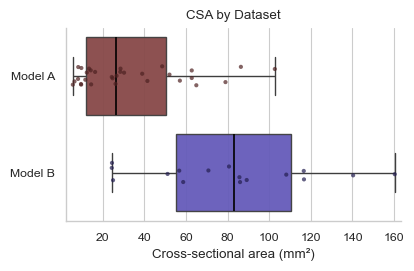

In [18]:
# ---- Paste your two columns below (no headers needed). Tabs/commas/spaces OK. ----
raw = """
102.7	160.3
86.4	140.3
79.0	116.7
65.0	116.6
62.8	108.2
62.8	89.2
57.1	86.0
52.1	85.7
48.6	80.7
41.5	70.8
39.0	58.7
30.3	56.8
28.6	51.2
28.5	25.0
26.7	24.5
26.2	24.4
24.8	
24.4	
16.4	
14.5	
14.3	
13.5	
12.4	
11.7	
9.8	
9.7	
9.6	
8.3	
8.2	
6.5	
5.7	
"""


# --------------------- No edits needed below this line ---------------------
import io
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def _read_two_cols(text: str) -> pd.DataFrame:
    text = text.strip()
    if not text:
        raise ValueError("No data found. Paste two numeric columns into the raw string.")

    # Explicitly use engine='python' where regex/whitespace splitting is expected
    attempts = [
        # CSV with commas
        lambda t: pd.read_csv(io.StringIO(t), header=None, sep=","),
        # TSV with regex tabs
        lambda t: pd.read_csv(io.StringIO(t), header=None, sep=r"\t+", engine="python"),
        # Any whitespace
        lambda t: pd.read_csv(io.StringIO(t), header=None, delim_whitespace=True, engine="python"),
        # Normalize spaces/commas/tabs to single tab then parse as TSV
        lambda t: pd.read_csv(
            io.StringIO(re.sub(r"[ ,\t]+", "\t", t)),
            header=None,
            sep="\t",
            engine="python",
        ),
    ]

    for attempt in attempts:
        try:
            df = attempt(text)
            if df.shape[1] == 2:
                return df
        except Exception:
            pass

    raise ValueError("Could not parse two columns. Ensure you have exactly two numeric columns.")

# Parse
wide = _read_two_cols(raw)
wide.columns = ["Model A", "Model B"]

# Coerce to numeric and keep NaNs (will be dropped per series)
for c in wide.columns:
    wide[c] = pd.to_numeric(wide[c], errors="coerce")

# Long format
long = wide.melt(var_name="Dataset", value_name="CSA_mm2").dropna(subset=["CSA_mm2"])

# ---- Plotting ----
sns.set_theme(context="paper", style="whitegrid", palette="colorblind")
fig, ax = plt.subplots(figsize=(4.2, 2.8))  # single-column friendly

# Choose a palette (two distinct, colorblind-friendly colors)
palette = {
    "Model A": "#923d3d",  # red
    "Model B": "#584bca",  # blue
}

point_palette = {
    "Model A": "#4e2121",  # red
    "Model B": "#231e50",  # blue
}

# Box/whisker (horizontal) — set hue to match y, hide legend
sns.boxplot(
    data=long, y="Dataset", x="CSA_mm2",
    orient="h",
    hue="Dataset",
    palette=palette,
    showcaps=True,
    boxprops=dict(alpha=0.95),
    whiskerprops=dict(linewidth=1),
    medianprops=dict(color="black", linewidth=1.2),
    fliersize=0,
    ax=ax,
    dodge=False,      
    legend=False,
)

# Jittered points overlaid with matching colors
sns.stripplot(
    data=long, y="Dataset", x="CSA_mm2",
    orient="h",
    hue="Dataset",
    palette=point_palette,
    dodge=False,
    size=3.0,
    alpha=0.7,
    ax=ax,
    legend=False,
)

# Remove any auto-created legend (older seaborn versions)
if ax.get_legend() is not None:
    ax.get_legend().remove()

# Labels and tidy up
ax.set_xlabel("Cross-sectional area (mm²)")
ax.set_ylabel("")
ax.set_title("CSA by Dataset")
ax.spines[["top", "right"]].set_visible(False)
ax.margins(x=0.02)

plt.tight_layout()
plt.show()

# Optional: export for publication (uncomment when needed)
# fig.savefig("fig_csa_boxpoints.png", dpi=300, bbox_inches="tight", pad_inches=0.02)
# fig.savefig("fig_csa_boxpoints.pdf", bbox_inches="tight", pad_inches=0.02)  # vector

